In [13]:
from fastai.conv_learner import *
from fastai.dataset import *
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
import math


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [14]:
MODEL_NAME = 'Resnet50'
PATH  = "./input"
TRAIN = f'{PATH}/train/'
TEST = f'{PATH}/test/'
LABELS = f'{PATH}/train.csv'
SAMPLE_SUB = f'{PATH}/sample_submission.csv'
BBOX = f'{PATH}/bboxes.csv'

In [15]:
# Backbone architecture
arch = resnet50
# Number of workers for data preprocessing
num_workers = 6

In [16]:
df = pd.read_csv(LABELS).set_index('Image')
new_whale_df = df[df.Id == "new_whale"] # only new_whale dataset

train_df = df[~(df.Id == "new_whale")] # no new_whale dataset, used for training
unique_labels = np.unique(train_df.Id.values)

labels_dict = dict()
labels_list = []
for i in range(len(unique_labels)):
    labels_dict[unique_labels[i]] = i
    labels_list.append(unique_labels[i])
print("Number of classes: {}".format(len(unique_labels)))
train_names = train_df.index.values
train_df.Id = train_df.Id.apply(lambda x: labels_dict[x])
train_labels = np.asarray(train_df.Id.values)

test_names = [f for f in os.listdir(TEST)]

Number of classes: 5004


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Count for class new_whale: 1


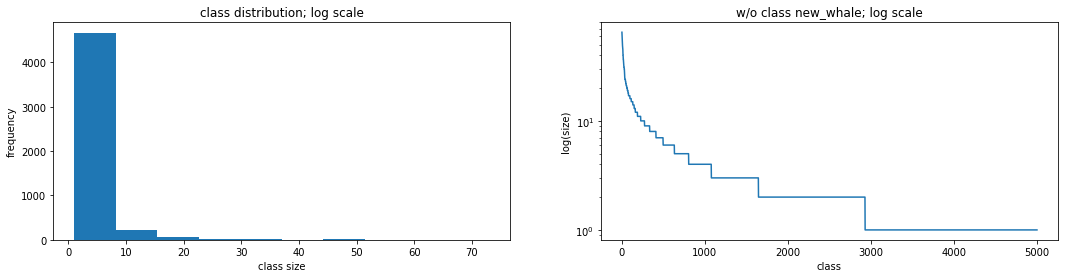

In [17]:
labels_count = train_df.Id.value_counts()

plt.figure(figsize=(18, 4))
plt.subplot(121)
_, _,_ = plt.hist(labels_count.values)
plt.ylabel("frequency")
plt.xlabel("class size")

plt.title('class distribution; log scale')
labels_count.head()

print("Count for class new_whale: {}".format(labels_count[0]))
plt.subplot(122)
_ = plt.plot(labels_count[1:].values)
plt.title('w/o class new_whale; log scale')
plt.xlabel("class")
plt.ylabel("log(size)")
plt.gca().set_yscale('log')

In [18]:
train_df['image_name'] = train_df.index
bbox_df = pd.read_csv(BBOX).set_index('Image')

rs = np.random.RandomState(42) # set random seed to be equal to the sense of life
perm = rs.permutation(len(train_df))

tr_n = train_df['image_name'].values
# Yes, we will validate on the subset of training data
val_n = train_df['image_name'].values[perm][:1000]

print('Train/val:', len(tr_n), len(val_n))
print('Train classes', len(train_df.loc[tr_n].Id.unique()))
print('Val classes', len(train_df.loc[val_n].Id.unique()))

Train/val: 15697 1000
Train classes 5004
Val classes 819


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
class HWIDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.train_df = train_df
        super().__init__(fnames, transform, path)

    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        img = cv2.resize(img, (self.sz, self.sz))
        return img

    def get_y(self, i):
        if (self.path == TEST): return 0
        return self.train_df.loc[self.fnames[i]]['Id']

    def get_c(self):
        return len(unique_labels)

In [26]:
class HWIDataset1(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.train_df = train_df
        super().__init__(fnames, transform, path)

    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        bbox = bbox_df.loc[self.fnames[i]]
        x0, y0, x1, y1 = bbox['x0'], bbox['y0'], bbox['x1'],  bbox['y1']
        if not (x0 >= x1 or y0 >= y1):
            img = img[y0:y1, x0:x1,:]
        img = cv2.resize(img, (self.sz, self.sz))
        return img

    def get_y(self, i):
        if (self.path == TEST): return 0
        return self.train_df.loc[self.fnames[i]]['Id']

    def get_c(self):
        return len(unique_labels)



In [25]:
def get_data(sz, batch_size):
    """
    Read data and do augmentations
    """
    aug_tfms = [RandomRotateZoom(deg=20, zoom=2, stretch=1),
                RandomLighting(0.2, 0.2, tfm_y=TfmType.NO),
                RandomBlur(blur_strengths=3,tfm_y=TfmType.NO),
                RandomFlip(tfm_y=TfmType.NO)]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.NO,
                           aug_tfms=aug_tfms)
    ds = ImageData.get_ds(HWIDataset1, (tr_n[:-(len(tr_n) % batch_size)], TRAIN),
                          (val_n, TRAIN), tfms, test=(test_names, TEST))
    md = ImageData("./", ds, batch_size, num_workers=num_workers, classes=None)
    return md

In [9]:
!ls models

10_resnet19_im_4_20_10_cyc_0.h5  3_resnet50_cyc_2.h5
11_resnet19_im_4_20_10_cyc_0.h5  4_resnet19_im_4_20_10_cyc_0.h5
12_resnet19_im_4_20_10_cyc_0.h5  4_resnet50_cyc_0.h5
12_resnet19_im_4_20_10_cyc_1.h5  4_resnet50_cyc_1.h5
1_resnet50_2_cyc_0.h5		 4_resnet50_cyc_2.h5
1_resnet50_cyc_0.h5		 5_resnet19_im_4_20_10_cyc_0.h5
1_resnet53_cyc_0.h5		 6_resnet19_im_4_20_10_cyc_0.h5
1_resnet53_cyc_1.h5		 7_resnet19_im_4_20_10_cyc_0.h5
1_resnet53_cyc_2.h5		 8_resnet19_im_4_20_10_cyc_0.h5
2_resnet34_1_10_5_cyc_0.h5	 9_resnet19_im_4_20_10_cyc_0.h5
2_resnet34_2_10_5_cyc_0.h5	 acc_0_30_tta_subm1.h5
2_resnet50_2_cyc_0.h5		 d3_resnet19_im_4_10_5_cyc_0.h5
2_resnet50_2_cyc_1.h5		 first_trainings.h5
2_resnet50_2_cyc_2.h5		 resnet19_1_20_16.h5
2_resnet50_cyc_0.h5		 resnet19_im_4_20_16_2_cyc_0.h5
2_resnet50_cyc_1.h5		 resnet19_im_4_20_16_cyc_0.h5
2_resnet50_cyc_2.h5		 resnet19_im_4_20_16_cyc_1.h5
34_fit_2.h5			 rn34_im_2_10_5_2_cyc_0.h5
3_resnet19_im_4_20_10_cyc_0.h5	 rn34_im_2_10_5_3_cyc_0.h5
3_resnet50_2_cyc

In [28]:
image_size = 224
batch_size = 96
md = get_data(image_size, batch_size)

In [29]:
extra_fc_layers_size = []
learn = ConvLearner.pretrained(arch, md, xtra_fc=extra_fc_layers_size) 
learn.opt_fn = optim.Adam

In [11]:
print('Number of layer groups:', len(learn.get_layer_groups()), '\t(first 2 groups is pretrained backbone)')
print('This is our extra thin on top of the backbone Resnet50 architecture:')
learn.get_layer_groups()[2]

Number of layer groups: 3 	(first 2 groups is pretrained backbone)
This is our extra thin on top of the backbone Resnet50 architecture:


Sequential(
  (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Dropout(p=0.5)
  (2): Linear(in_features=4096, out_features=5004, bias=True)
  (3): LogSoftmax()
)

In [10]:
!ls "models"

10_resnet19_im_4_20_10_cyc_0.h5  3_resnet50_cyc_2.h5
11_resnet19_im_4_20_10_cyc_0.h5  4_resnet19_im_4_20_10_cyc_0.h5
12_resnet19_im_4_20_10_cyc_0.h5  4_resnet50_cyc_0.h5
12_resnet19_im_4_20_10_cyc_1.h5  4_resnet50_cyc_1.h5
1_resnet50_2_cyc_0.h5		 4_resnet50_cyc_2.h5
1_resnet50_cyc_0.h5		 5_resnet19_im_4_20_10_cyc_0.h5
1_resnet53_cyc_0.h5		 6_resnet19_im_4_20_10_cyc_0.h5
1_resnet53_cyc_1.h5		 7_resnet19_im_4_20_10_cyc_0.h5
1_resnet53_cyc_2_new1.h5	 8_resnet19_im_4_20_10_cyc_0.h5
1_resnet53_cyc_2_orig.h5	 9_resnet19_im_4_20_10_cyc_0.h5
2_resnet34_1_10_5_cyc_0.h5	 acc_0_30_tta_subm1.h5
2_resnet34_2_10_5_cyc_0.h5	 d3_resnet19_im_4_10_5_cyc_0.h5
2_resnet50_2_cyc_0.h5		 first_trainings.h5
2_resnet50_2_cyc_1.h5		 resnet19_1_20_16.h5
2_resnet50_2_cyc_2.h5		 resnet19_im_4_20_16_2_cyc_0.h5
2_resnet50_cyc_0.h5		 resnet19_im_4_20_16_cyc_0.h5
2_resnet50_cyc_1.h5		 resnet19_im_4_20_16_cyc_1.h5
2_resnet50_cyc_2.h5		 rn34_im_2_10_5_2_cyc_0.h5
34_fit_2.h5			 rn34_im_2_10_5_3_cyc_0.h5
3_resnet19_im_4_20

learn.load("1_resnet53_cyc_2_orig")

In [19]:
base_lr = 1e-4 # lr for the backbone
fc_lr = 1e-3 # lr for the classifer

lrs = [base_lr, base_lr, fc_lr]
# Freeze backbone and train the classifier for 2 epochs
learn.fit(lrs=lrs, n_cycle=2, cycle_len=None)


epoch      trn_loss   val_loss   accuracy                   
    0      7.921878   5.958249   0.141     
    1      6.783223   4.133805   0.348                      


[4.133804647445679, 0.34800001311302187]

In [20]:
image_size = 384
batch_size = 32
md = get_data(image_size, batch_size)
learn.set_data(md)

In [21]:
base_lr = 1e-4 # lr for the backbone
fc_lr = 1e-3 # lr for the classifer

lrs = [base_lr, base_lr, fc_lr]
# Freeze backbone and train the classifier for 2 epochs
learn.fit(lrs=lrs, n_cycle=2, cycle_len=None)


epoch      trn_loss   val_loss   accuracy                   
    0      7.361127   4.610442   0.299     
    1      6.326503   2.764786   0.526                      


[2.764785575866699, 0.526]

In [22]:
# Unfreeze backbone and continue training for 9 epochs
learn.unfreeze()
learn.fit(lrs, n_cycle=3, cycle_len=2, use_clr=(10, 5), cycle_save_name="1_resnet54")

epoch      trn_loss   val_loss   accuracy                   
    0      5.849788   2.992251   0.55      
    1      4.00602    1.572949   0.769                      
    2      3.807507   0.956489   0.845                      
    3      1.810677   0.29039    0.95                       
    4      2.044308   0.172337   0.965                      
    5      0.765801   0.025503   0.997                       


[0.02550307512283325, 0.997]

base_lr = 1e-4 # lr for the backbone
fc_lr = 1e-3 # lr for the classifer

lrs = [base_lr, base_lr, fc_lr]

# Unfreeze backbone and continue training for 9 epochs
learn.unfreeze()
learn.fit(lrs, n_cycle=3, cycle_len=2, use_clr=(10, 5), cycle_save_name="1_resnet53")

In [23]:
best_th = 0.38

In [33]:
preds_t,y_t = learn.TTA(is_test=True,n_aug=8)
np.save("preds_whale50_4", preds_t)

In [36]:
preds_sans_0 = preds_t

In [37]:
preds_t = np.stack(preds_t, axis=-1)
preds_t = np.exp(preds_t)
preds_t = preds_t.mean(axis=-1)
preds_t = np.concatenate([np.zeros((preds_t.shape[0],1))+best_th, preds_t],axis=1)

In [20]:
preds_t = np.load("preds_whale50_4_box_preds.npy")

In [25]:
np.save("preds_whale50_4_box_preds", preds_t)

In [22]:
labels_list

['w_0003639',
 'w_0003c59',
 'w_0027efa',
 'w_00289b1',
 'w_002c810',
 'w_0032a46',
 'w_003bae6',
 'w_00656c0',
 'w_0066399',
 'w_007fefa',
 'w_00904a7',
 'w_009c9c5',
 'w_00a41ba',
 'w_00b3dc2',
 'w_00d50c9',
 'w_00d5466',
 'w_00d5e98',
 'w_00f340d',
 'w_010f858',
 'w_0115c24',
 'w_0118bab',
 'w_012678c',
 'w_0135f5f',
 'w_0140c92',
 'w_015a4bf',
 'w_016f0ea',
 'w_0182687',
 'w_0189b6d',
 'w_01976db',
 'w_01a1d88',
 'w_01cb0c4',
 'w_01cbbbd',
 'w_01d790e',
 'w_01e1b97',
 'w_01e1fe0',
 'w_01ed442',
 'w_01f14e1',
 'w_01fc429',
 'w_02156b0',
 'w_022b708',
 'w_022d2f5',
 'w_02469a1',
 'w_02545ea',
 'w_025911c',
 'w_0277a07',
 'w_027f528',
 'w_0292e15',
 'w_02aa597',
 'w_02c7e9d',
 'w_02d138d',
 'w_02d5c46',
 'w_02e8199',
 'w_02ff6d6',
 'w_0301302',
 'w_030ac9b',
 'w_030c8b0',
 'w_030e2cf',
 'w_03193e5',
 'w_031e1a3',
 'w_0323574',
 'w_03270e3',
 'w_0350bf4',
 'w_03670aa',
 'w_0369a5c',
 'w_036bc54',
 'w_036dbd0',
 'w_037b23f',
 'w_038dfc0',
 'w_038e5c3',
 'w_03a82c1',
 'w_03ad89c',
 'w_03

In [37]:
submission_name = "submission50_4__box"
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.Image)
labels_list = ["new_whale"]+labels_list if labels_list[0] != "new_whale" else labels_list
pred_list = [[labels_list[i] for i in p.argsort()[-5:][::-1]] for p in preds_t]
pred_dic = dict((key, value) for (key, value) in zip(learn.data.test_ds.fnames,pred_list))
pred_list_cor = [' '.join(pred_dic[id]) for id in sample_list]
df = pd.DataFrame({'Image':sample_list,'Id': pred_list_cor})
df.to_csv(f'{submission_name}.csv', header=True, index=False)
df.head()

,Image,Id
0,00028a005.jpg,new_whale w_df6b050 w_04003e9 w_dec7ffd w_a87ec7e
1,000dcf7d8.jpg,w_4132bb8 new_whale w_e3956f5 w_351a377 w_5cf4727
2,000e7c7df.jpg,new_whale w_4344f5e w_1f0cf0a w_a743e09 w_cd4cb49
3,0019c34f4.jpg,new_whale w_9c506f6 w_c99807e w_91b678a w_36bbd71
4,001a4d292.jpg,w_4a12050 new_whale w_9e18daa w_502e72f w_69bb761


In [38]:
labels_list

['new_whale',
 'w_0003639',
 'w_0003c59',
 'w_0027efa',
 'w_00289b1',
 'w_002c810',
 'w_0032a46',
 'w_003bae6',
 'w_00656c0',
 'w_0066399',
 'w_007fefa',
 'w_00904a7',
 'w_009c9c5',
 'w_00a41ba',
 'w_00b3dc2',
 'w_00d50c9',
 'w_00d5466',
 'w_00d5e98',
 'w_00f340d',
 'w_010f858',
 'w_0115c24',
 'w_0118bab',
 'w_012678c',
 'w_0135f5f',
 'w_0140c92',
 'w_015a4bf',
 'w_016f0ea',
 'w_0182687',
 'w_0189b6d',
 'w_01976db',
 'w_01a1d88',
 'w_01cb0c4',
 'w_01cbbbd',
 'w_01d790e',
 'w_01e1b97',
 'w_01e1fe0',
 'w_01ed442',
 'w_01f14e1',
 'w_01fc429',
 'w_02156b0',
 'w_022b708',
 'w_022d2f5',
 'w_02469a1',
 'w_02545ea',
 'w_025911c',
 'w_0277a07',
 'w_027f528',
 'w_0292e15',
 'w_02aa597',
 'w_02c7e9d',
 'w_02d138d',
 'w_02d5c46',
 'w_02e8199',
 'w_02ff6d6',
 'w_0301302',
 'w_030ac9b',
 'w_030c8b0',
 'w_030e2cf',
 'w_03193e5',
 'w_031e1a3',
 'w_0323574',
 'w_03270e3',
 'w_0350bf4',
 'w_03670aa',
 'w_0369a5c',
 'w_036bc54',
 'w_036dbd0',
 'w_037b23f',
 'w_038dfc0',
 'w_038e5c3',
 'w_03a82c1',
 'w_03

In [31]:
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.Image)
labels_list = ["new_whale"]+labels_list if labels_list[0] != "new_whale" else labels_list
pred_list = [[labels_list[i] for i in p.argsort()[-5:][::-1]] for p in preds_new]
pred_dic = dict((key, value) for (key, value) in zip(md.test_ds.fnames,pred_list))
pred_list_cor = [' '.join(pred_dic[id]) for id in sample_list]
df = pd.DataFrame({'Image':sample_list,'Id': pred_list_cor})
df.to_csv('submission50_ensemble_4_box.csv', header=True, index=False)
df.head()

TypeError: only integer scalar arrays can be converted to a scalar index

In [32]:
labels_list

['new_whale',
 'w_0003639',
 'w_0003c59',
 'w_0027efa',
 'w_00289b1',
 'w_002c810',
 'w_0032a46',
 'w_003bae6',
 'w_00656c0',
 'w_0066399',
 'w_007fefa',
 'w_00904a7',
 'w_009c9c5',
 'w_00a41ba',
 'w_00b3dc2',
 'w_00d50c9',
 'w_00d5466',
 'w_00d5e98',
 'w_00f340d',
 'w_010f858',
 'w_0115c24',
 'w_0118bab',
 'w_012678c',
 'w_0135f5f',
 'w_0140c92',
 'w_015a4bf',
 'w_016f0ea',
 'w_0182687',
 'w_0189b6d',
 'w_01976db',
 'w_01a1d88',
 'w_01cb0c4',
 'w_01cbbbd',
 'w_01d790e',
 'w_01e1b97',
 'w_01e1fe0',
 'w_01ed442',
 'w_01f14e1',
 'w_01fc429',
 'w_02156b0',
 'w_022b708',
 'w_022d2f5',
 'w_02469a1',
 'w_02545ea',
 'w_025911c',
 'w_0277a07',
 'w_027f528',
 'w_0292e15',
 'w_02aa597',
 'w_02c7e9d',
 'w_02d138d',
 'w_02d5c46',
 'w_02e8199',
 'w_02ff6d6',
 'w_0301302',
 'w_030ac9b',
 'w_030c8b0',
 'w_030e2cf',
 'w_03193e5',
 'w_031e1a3',
 'w_0323574',
 'w_03270e3',
 'w_0350bf4',
 'w_03670aa',
 'w_0369a5c',
 'w_036bc54',
 'w_036dbd0',
 'w_037b23f',
 'w_038dfc0',
 'w_038e5c3',
 'w_03a82c1',
 'w_03

In [39]:
!ls

Ensemble.ipynb			submission50_4__box.csv
Whales-Copy1.ipynb		submission50_ensemble_1_box.csv
Whales.ipynb			submission50_ensemble_2_box.csv
fastai				submission50_ensemble_3_box.csv
input				submission50_ensemble_4_box.csv
learn_whales.ipynb		submission_Resnet50.csv
models				submission_rn_2.csv
preds_whale50_1_preds_0587.npy	tmp
preds_whale50_2_preds.npy	whales50-V2.ipynb
preds_whale50_3_preds.npy	whales50-V3.ipynb
preds_whale50_4.npy		whales50-V4.ipynb
preds_whale50_4_box_preds.npy	whales50.ipynb
submission.csv			{submission_name}.csv
submission1.csv


In [40]:
!kaggle competitions submit -c humpback-whale-identification -f "submission50_4__box.csv" -m "resnet50 v5 train no whale, bbox 4 fix"

100%|#########################################| 498k/498k [00:04<00:00, 121kB/s]
Successfully submitted to Humpback Whale Identification